In [13]:
# --- 核心库 ---
import xarray as xr
from datetime import datetime, timezone
from pathlib import Path
import numpy as np
import io

# --- 项目模块 ---
from chromasky_toolkit import config
from chromasky_toolkit.glow_index import GlowIndexCalculator
from chromasky_toolkit.map_drawer import generate_map_from_grid
from IPython.display import display, Image

# --- 辅助函数 ---
def print_mask_friendly(mask: xr.DataArray, downsample_factor: int = 4):
    """以友好的字符形式打印布尔掩码，用于直观展示。"""
    if not isinstance(mask, xr.DataArray) or mask.dtype != bool:
        print("错误：输入必须是布尔型的 xarray.DataArray。")
        return
    resampled_mask = mask.coarsen(
        latitude=downsample_factor, longitude=downsample_factor, boundary="pad"
    ).max().astype(bool)
    lat_coords, lon_coords, mask_values = resampled_mask.latitude.values, resampled_mask.longitude.values, resampled_mask.values
    print(" " * 5, end="")
    for i in range(0, len(lon_coords), 5): print(f"{lon_coords[i]:<5.1f}", end="")
    print("\n")
    for i, lat in enumerate(lat_coords):
        print(f"{lat:>4.1f} ", end="")
        for val in mask_values[i, :]: print('■' if val else '·', end="")
        print("")
    print(f"\n图例: ■ = 计算区域 (True), · = 非计算区域 (False)")
    print(f"注意: 图像已按因子 {downsample_factor} 降采样以适应显示。")

print("✅ 环境设置完毕。")

✅ 环境设置完毕。


In [14]:
# ======================================================================
# --- 核心配置区：请在此处设置您的目标参数 ---
# ======================================================================

# 1. 设置您想分析的 UTC 日期和时间
TARGET_UTC_DATE = "2025-07-18"
TARGET_UTC_HOUR = 11  # 只需输入小时的整数

# 2. 设置您想分析的天文事件 ('sunrise' 或 'sunset')
EVENT_TYPE = "sunset"

# 3. 设置时间窗口的半径（分钟）
EVENT_WINDOW_MINUTES = 30

In [15]:
# --- 1. 根据配置自动构建路径和时间对象 ---
target_time_str = f"{TARGET_UTC_DATE}T{TARGET_UTC_HOUR:02d}:00:00"
observation_time = datetime.fromisoformat(target_time_str).replace(tzinfo=timezone.utc)
hcc_filename = f"hcc_{TARGET_UTC_HOUR:02d}00.nc"
processed_data_path = config.PROCESSED_DATA_DIR / TARGET_UTC_DATE / hcc_filename

print("--- 自动配置信息 ---")
print(f"目标观测时间 (UTC): {observation_time}")
print(f"目标天文事件: {EVENT_TYPE} (窗口: ±{EVENT_WINDOW_MINUTES}分钟)")
print(f"将要加载的数据文件: {processed_data_path}")
print("-" * 50)


# --- 2. 加载数据 ---
if not processed_data_path.exists():
    raise FileNotFoundError(f"数据文件未找到: {processed_data_path}")
hcc_slice = xr.open_dataarray(processed_data_path)
print("✅ hcc 数据加载成功!")


# --- 3. 初始化计算器 ---
calculator = GlowIndexCalculator(hcc_data=hcc_slice)


# --- 4. 计算天文事件掩码并打印 ---
active_region_mask = calculator.astro_service.create_event_mask(
    hcc_slice.latitude, hcc_slice.longitude, observation_time, EVENT_TYPE, EVENT_WINDOW_MINUTES
)
print("\n" + "="*80)
print("--- 天文事件掩码 (友好打印) ---")
print_mask_friendly(active_region_mask, downsample_factor=4)
print("="*80 + "\n")


# --- 5. 执行网格计算 ---
glow_index_data = calculator.calculate_for_grid(
    utc_time=observation_time,
    active_mask=active_region_mask
)
print("\n✅ 火烧云指数网格计算完成!")

--- 自动配置信息 ---
目标观测时间 (UTC): 2025-07-18 11:00:00+00:00
目标天文事件: sunset (窗口: ±30分钟)
将要加载的数据文件: /Users/zhangchao/Documents/Code/github/chromasky-toolkit/src/data/processed/2025-07-18/hcc_1100.nc
--------------------------------------------------
✅ hcc 数据加载成功!


Calculating sunset times:   0%|          | 0/56637 [00:00<?, ?it/s]


--- 天文事件掩码 (友好打印) ---
     70.4 75.4 80.4 85.4 90.4 95.4 100.4105.4110.4115.4120.4125.4130.4135.0

53.6 ·······························································■■■
52.6 ······························································■■■■
51.6 ····························································■■■■■■
50.6 ···························································■■■■■■■
49.6 ··························································■■■■■■■■
48.6 ·························································■■■■■■■■■
47.6 ························································■■■■■■■■■■
46.6 ·······················································■■■■■■■■■■■
45.6 ······················································■■■■■■■■■■■■
44.6 ·····················································■■■■■■■■■■■■■
43.6 ····················································■■■■■■■■■■■■■■
42.6 ····················································■■■■■■■■■■■■■■
41.6 ·······························

Calculating Glow Index:   0%|          | 0/11569 [00:00<?, ?it/s]


✅ 火烧云指数网格计算完成!



✅ 地图已成功生成并保存到: /Users/zhangchao/Documents/Code/github/chromasky-toolkit/src/outputs/maps/glow_index/glow_index_20250718_1100.png
正在下方显示地图...


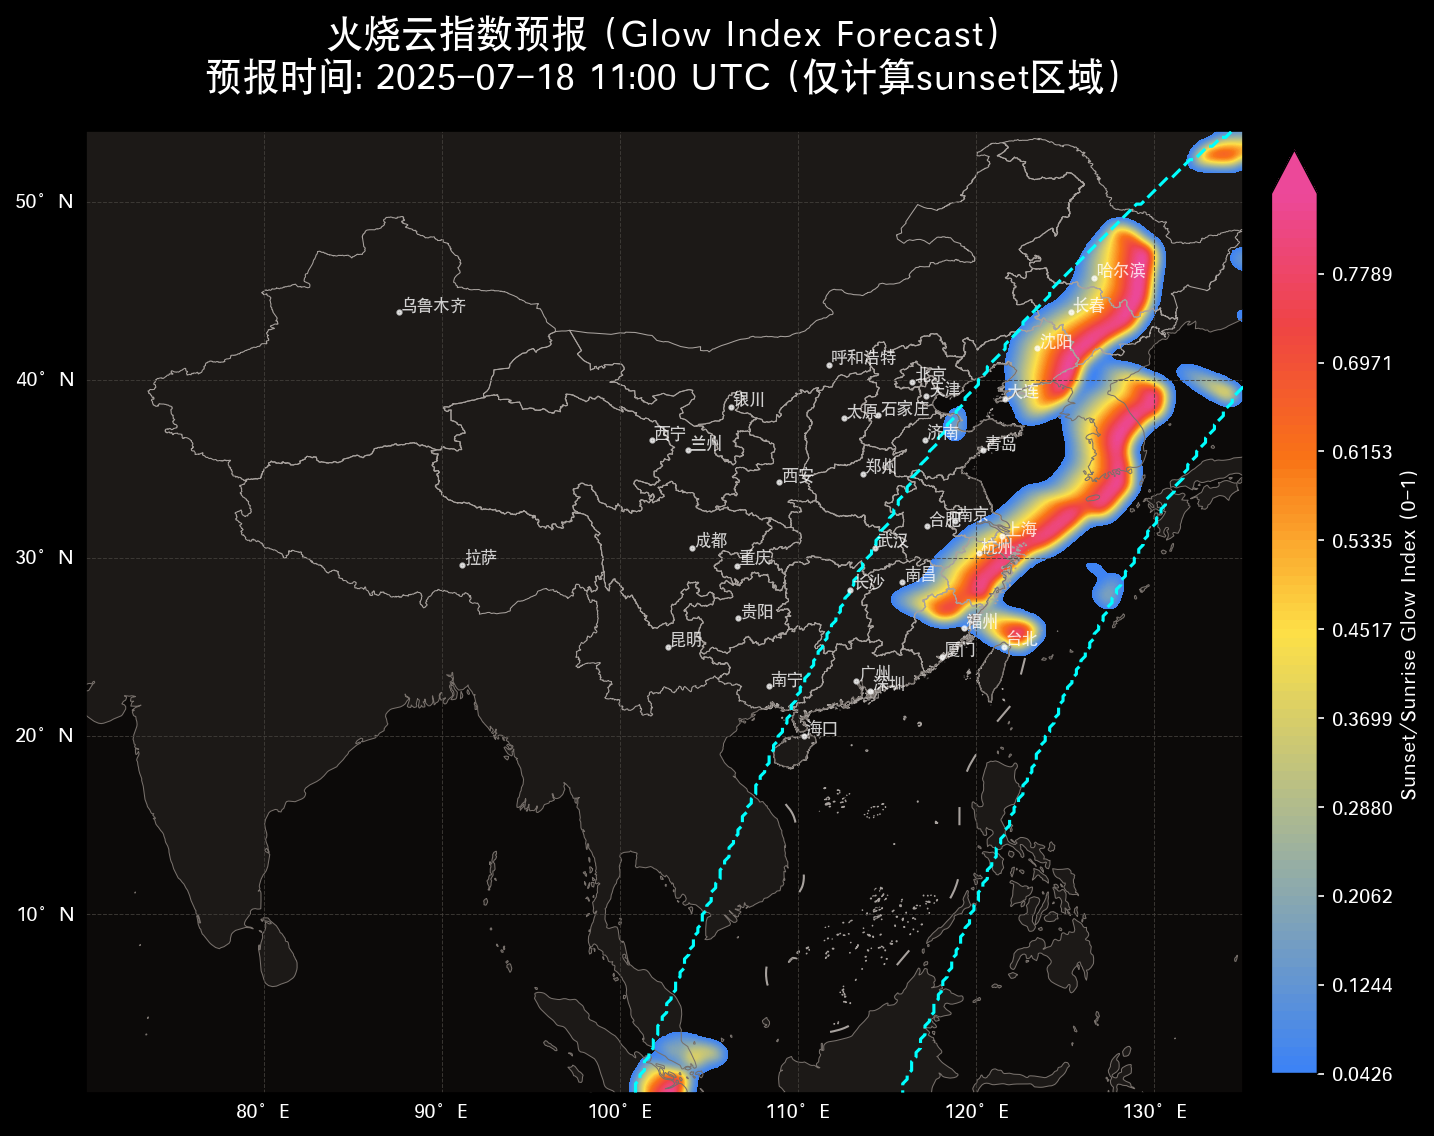

In [16]:
# --- 6. 调用绘图函数生成地图 ---
map_title = (
    f"火烧云指数预报 (Glow Index Forecast)\n"
    f"预报时间: {observation_time.strftime('%Y-%m-%d %H:%M UTC')} (仅计算{EVENT_TYPE}区域)"
)

output_dir = config.MAP_OUTPUTS_DIR / "glow_index"
output_dir.mkdir(parents=True, exist_ok=True)
map_output_path = output_dir / f"glow_index_{observation_time.strftime('%Y%m%d_%H%M')}.png"

image_bytes = generate_map_from_grid(
    score_grid=glow_index_data,
    title=map_title,
    output_path=map_output_path,
    active_region_mask=active_region_mask
)

# --- 7. 在 Notebook 中显示生成的地图 ---
if image_bytes:
    print(f"\n✅ 地图已成功生成并保存到: {map_output_path}")
    print("正在下方显示地图...")
    display(Image(data=image_bytes, width=800))
else:
    print("\n❌ 地图生成失败。")